<a href="https://colab.research.google.com/github/maldisco/deep-learning_tomato_pest_classification/blob/main/tomato_pest_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.chdir("gdrive/My Drive/Colab Notebooks/proj2-fsi")

Mounted at /content/gdrive


# Preparando o dataset

In [2]:
import numpy as np
import tensorflow as tf
import glob

# Dimensão das imagens
IMG_DIM = (299,299)
BATCH_SIZE = 32

# Criação do dataset (https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/)
# Conjunto de treino
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "tomato-pest",
  labels="inferred",             # classes inferidas pelas subpastas do diretório
  label_mode="categorical",      
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=IMG_DIM,
  batch_size=BATCH_SIZE)
# Conjunto de validação
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "tomato-pest",
  labels="inferred",             
  label_mode="categorical",      
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=IMG_DIM,
  batch_size=BATCH_SIZE)

Found 4263 files belonging to 8 classes.
Using 2985 files for training.
Found 4263 files belonging to 8 classes.
Using 1278 files for validation.


# Visualização dos dados

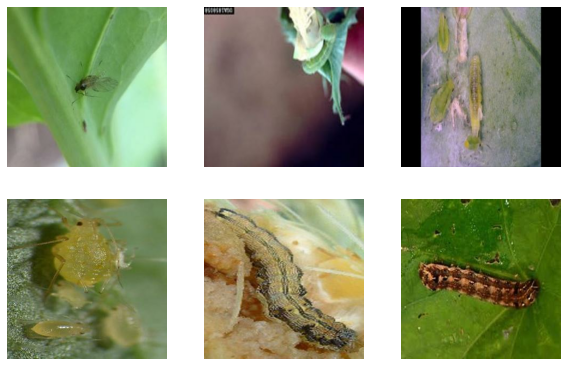

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.axis("off")

# Construindo o modelo pré-treinado utilizando a rede ResNET50

In [5]:
from keras.applications.resnet import ResNet50
import keras

# Alguns trechos foram retirados de 
# https://medium.com/@kenneth.ca95/a-guide-to-transfer-learning-with-keras-using-resnet50-a81a4a28084b

# Formato da entrada
input_t = keras.Input(shape=(299,299,3))
# Modelo da rede resnet50
resnet_model = ResNet50(include_top=False, weights='imagenet', classes=8, input_tensor=input_t)

# Tornando (quase) todas as camadas da rede não-treináveis
for layer in resnet_model.layers[:143]: 
  layer.trainable=False

94781440/94765736 [==============================] - 1s 0us/step


### Composição do modelo

In [6]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers

# Dimensões de entrada da rede
input_shape=resnet_model.output_shape[1]

# Definição das camadas do modelo da rede
out = resnet_model.output
out = GlobalAveragePooling2D()(out)
out = Dense(126, activation='relu')(out)
out = Dropout(0.5)(out)                                    # Camada de dropout para evitar overfitting
predictions = Dense(8, activation='softmax')(out)
model = Model(inputs=resnet_model.input, outputs=predictions)

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=.0001), metrics=['accuracy'])

### Treinamento do modelo

In [7]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=10,
                    verbose=1)

model.save('tomato-plague_detection.h5')

Epoch 1/10
94/94 [==============================] - 460s 5s/step - loss: 0.8549 - accuracy: 0.7085 - val_loss: 0.4374 - val_accuracy: 0.8897
Epoch 2/10
94/94 [==============================] - 63s 660ms/step - loss: 0.1601 - accuracy: 0.9581 - val_loss: 0.1704 - val_accuracy: 0.9421
Epoch 3/10
94/94 [==============================] - 62s 659ms/step - loss: 0.0672 - accuracy: 0.9819 - val_loss: 0.1952 - val_accuracy: 0.9397
Epoch 4/10
94/94 [==============================] - 62s 657ms/step - loss: 0.0474 - accuracy: 0.9896 - val_loss: 0.1940 - val_accuracy: 0.9484
Epoch 5/10
94/94 [==============================] - 62s 657ms/step - loss: 0.0267 - accuracy: 0.9916 - val_loss: 0.1163 - val_accuracy: 0.9577
Epoch 6/10
94/94 [==============================] - 62s 658ms/step - loss: 0.0180 - accuracy: 0.9953 - val_loss: 0.1838 - val_accuracy: 0.9390
Epoch 7/10
94/94 [==============================] - 62s 657ms/step - loss: 0.0124 - accuracy: 0.9973 - val_loss: 0.1169 - val_accuracy: 0.9687
E

### Plotagem da história do modelo (Acurácia e perda)

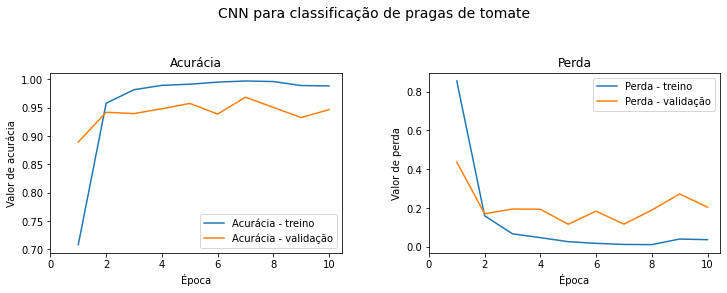

In [8]:
from matplotlib import pyplot as plt

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN para classificação de pragas de tomate', fontsize=14)
f.subplots_adjust(top=0.75, wspace=0.3)

epoch_list = list(range(1,11))
# Acurácia
ax1.plot(epoch_list, history.history['accuracy'], label='Acurácia - treino')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Acurácia - validação')
ax1.set_xticks(np.arange(0, 11, 2))
ax1.set_ylabel('Valor de acurácia')
ax1.set_xlabel('Época')
ax1.set_title('Acurácia')
l1 = ax1.legend(loc="best")

# Perda
ax2.plot(epoch_list, history.history['loss'], label='Perda - treino')
ax2.plot(epoch_list, history.history['val_loss'], label='Perda - validação')
ax2.set_xticks(np.arange(0, 11, 2))
ax2.set_ylabel('Valor de perda')
ax2.set_xlabel('Época')
ax2.set_title('Perda')
l2 = ax2.legend(loc="best")

# Carregamento do modelo armazenado (opcional)

In [4]:
import keras
model = keras.models.load_model('tomato-plague_detection.h5')

# Predições e avaliações

### Função de avaliação

In [11]:
from sklearn.metrics import multilabel_confusion_matrix

def get_metrics(true_label, predictions, class_names):
    print(f"Classe    Acurácia    Revocação     F1")
    for name, cm in zip(class_names, multilabel_confusion_matrix(true_label, predictions)):
      tn, fn, tp, fp = cm[0][0], cm[1][0], cm[1][1], cm[0][1]
      accuracy = (tp+tn)/(tp+tn+fp+fn)
      sensitivity = tp/(tp+fn)
      precision = tp/(tp+fp)
      recall = tp/(tp+fn)
      f1 = 2*((precision*recall)/(precision+recall))
      print(f"{str(name).ljust(10)}{str(round(accuracy,5)).ljust(12)}{str(round(sensitivity,5)).ljust(14)}{str(round(f1,5)).ljust(5)}")

### Predições

In [9]:
true_label = []
predictions = []

# Iterando entre todo o conjunto de validação e extraindo as predições e labels
for img, label in val_ds.as_numpy_iterator():
  prediction = model.predict(img)
  predictions.extend(list(np.argmax(prediction, axis=1))) 
  true_label.extend(list(np.argmax(label, axis=1))) 

### Avaliação

Acurácia, revocação (ou sensitivity) e f1-score para cada uma das classes

In [12]:
class_names=['BA','HA','MP','SE','SI','TP','TU','ZC']
get_metrics(true_label, predictions, class_names)

Classe    Acurácia    Revocação     F1
BA        0.99452     1.0           0.97071
HA        0.97105     0.87037       0.91041
MP        0.98122     0.98944       0.95904
SE        0.97653     0.92814       0.91176
SI        0.982       0.90104       0.93767
TP        0.99765     0.9375        0.96774
TU        0.99061     0.98204       0.96471
ZC        1.0         1.0           1.0  
